In [1]:
import numpy as np 
import pandas as pd 
import os
import sys
import time
from collections import defaultdict

# Image Processing & Computer Vision
import cv2

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Data Visualization
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.2)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

2024-08-19 12:22:19.873494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 12:22:19.873592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 12:22:20.052127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

meta = get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [3]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df
summary(meta).style.background_gradient('Purples')

,dtypes,count,unique,missing#,missing%
videoname,object,95634,95634,0,0.000000
original_width,int64,95634,31,0,0.000000
original_height,int64,95634,34,0,0.000000
label,object,95634,2,0,0.000000
original,object,79341,16955,16293,0.170368


In [4]:
print('Fake Images:', len(meta[meta.label=='FAKE']))
print('Real Images:', len(meta[meta.label=='REAL']))

Fake Images: 79341
Real Images: 16293


In [5]:
real_df = meta[meta['label'] == 'REAL']
fake_df = meta[meta['label'] == 'FAKE']
sample_size = 16000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [6]:
Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])

# (Rows, Columns)
print(f'Train Set: {Train_set.shape}')
print(f'Validation Set: {Val_set.shape}')
print(f'Test Set: {Test_set.shape}')

Train Set: (17920, 5)
Validation Set: (7680, 5)
Test Set: (6400, 5)


In [7]:
def plot_class_counts(train_set, val_set, test_set):
    sets = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['#52A666', '#C15B4E']
    
    y = {
        'REAL': [np.sum(train_set == 'REAL'), np.sum(val_set == 'REAL'), np.sum(test_set == 'REAL')],
        'FAKE': [np.sum(train_set == 'FAKE'), np.sum(val_set == 'FAKE'), np.sum(test_set == 'FAKE')]
    }
    
    trace0 = go.Bar(x=sets, y=y['REAL'], name='REAL', marker={'color': colors[0]}, opacity=0.7)
    trace1 = go.Bar(x=sets, y=y['FAKE'], name='FAKE', marker={'color': colors[1]}, opacity=0.7)
    
    data = [trace0, trace1]
    layout = go.Layout(title='Count of Classes in each set:', xaxis={'title': 'Set'}, yaxis={'title': 'Count'})
    
    fig = go.Figure(data, layout)
    iplot(fig)
    
plot_class_counts(np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label']))

In [8]:
plt.figure(figsize=(15,15), dpi=300)
for idx,i in enumerate(Train_set.index[75:100]):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.xlabel('FAKE Image' if Train_set.loc[i,'label']=='FAKE' else 'REAL Image')

plt.tight_layout()
plt.show()

In [9]:
# Function for getting image paths and corresponding labels from set
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, imgclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        labels.append(1 if imgclass == 'FAKE' else 0)
    return np.array(images), np.array(labels)

In [10]:
%%time

X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

CPU times: user 19.5 s, sys: 5.48 s, total: 25 s
Wall time: 3min 51s


In [11]:
X_train.shape

(17920, 224, 224, 3)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import VGG19

tf.keras.backend.clear_session()
tf.random.set_seed(42)

batch_size = 16

# Convert dataset to TensorFlow datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch datasets [size: 16]
train_set = train_set_raw.shuffle(1000, seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_set = valid_set_raw.batch(batch_size)
test_set = test_set_raw.batch(batch_size)

# Load the VGG19 model, excluding the top layers
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Internal Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Building the model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)

# Compile model with Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Print model summary
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,454,977 (78.03 MB)

 Trainable params: 20,453,185 (78.02 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
%%time

# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True, 
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'check.keras',  
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)

# Train the model
history = model.fit(
    train_set, 
    validation_data=valid_set, 
    epochs=50,
    callbacks=[early_stopping, model_checkpoint] 
)

Epoch 1/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5118 - loss: 1.0090
Epoch 1: val_loss improved from inf to 0.97799, saving model to check.keras
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 368s 306ms/step - accuracy: 0.5118 - loss: 1.0089 - val_accuracy: 0.5551 - val_loss: 0.9780
Epoch 2/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5253 - loss: 0.8822
Epoch 2: val_loss improved from 0.97799 to 0.67146, saving model to check.keras
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 343s 306ms/step - accuracy: 0.5253 - loss: 0.8822 - val_accuracy: 0.5764 - val_loss: 0.6715
Epoch 3/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5315 - loss: 0.8211
Epoch 3: val_loss did not improve from 0.67146
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 343s 306ms/step - accuracy: 0.5315 - loss: 0.8211 - val_accuracy: 0.6096 - val_loss: 0.6792
Epoch 4/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5471 - loss: 0.7710
Epoch 4: val_loss improved from 0.67146 to 0.65153, saving model to 

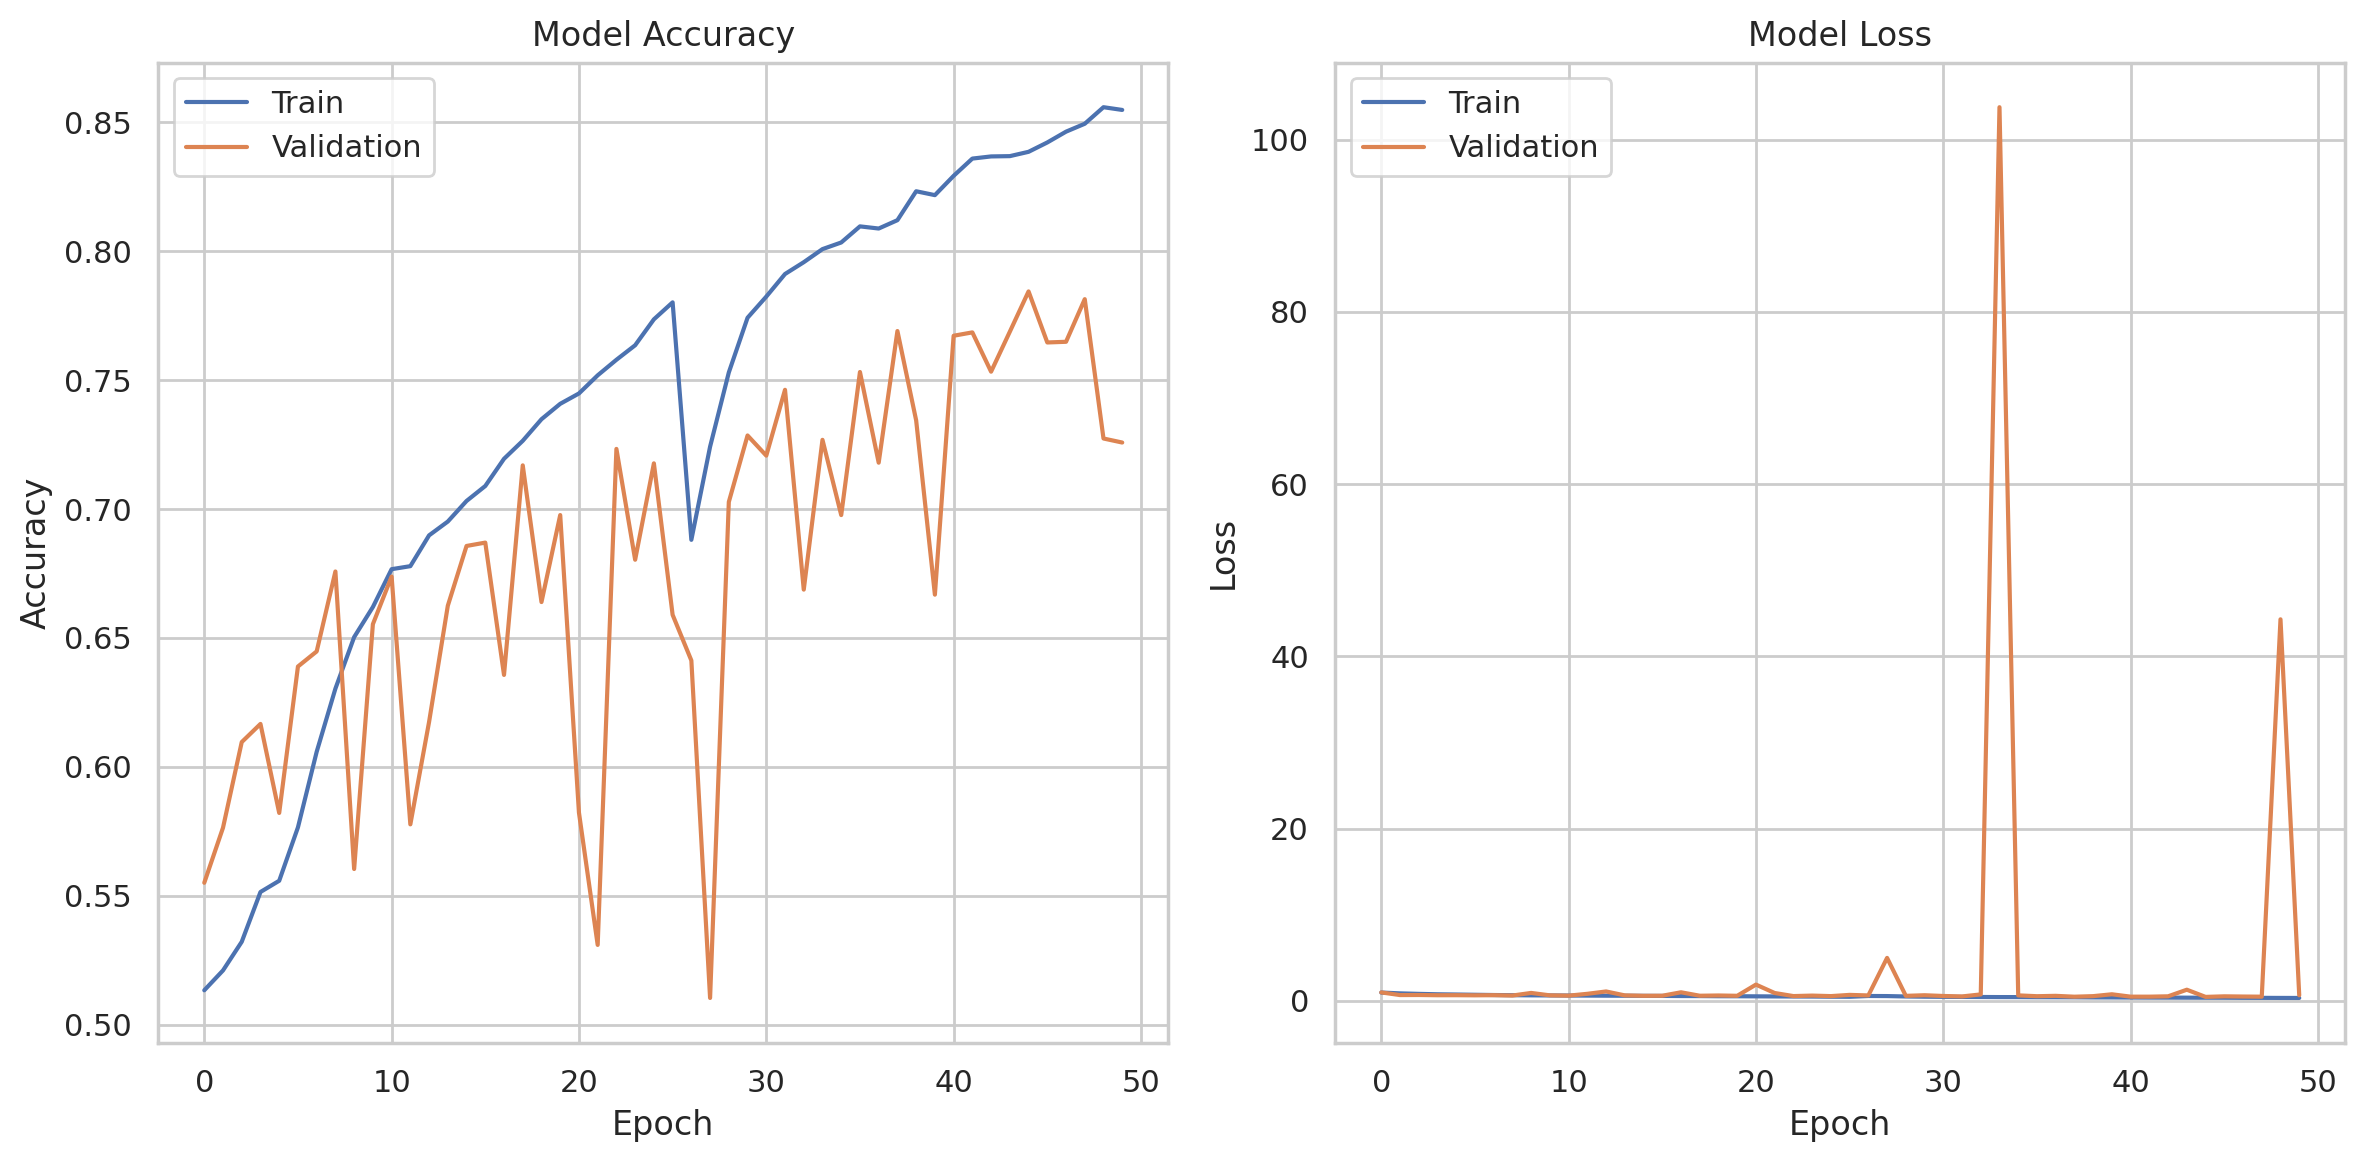

In [14]:
# Visualize training history
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 172ms/step - accuracy: 0.7971 - loss: 0.4425

Test Loss: 0.4408
Test Accuracy: 0.7931


In [16]:
import numpy as np
from sklearn.metrics import log_loss

# Assuming your test_set is a tf.data.Dataset and provides (image, label) pairs
# Get true labels from test_set
y_true = np.concatenate([y for x, y in test_set], axis=0)

# Get predicted probabilities from the model
y_pred = model.predict(test_set)
# Since the output layer has a sigmoid activation, y_pred gives probabilities for the positive class

# Calculate the log loss
loss = log_loss(y_true, y_pred)
print(f"Log Loss: {loss}")


400/400 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step
Log Loss: 0.4408158350430793


200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step


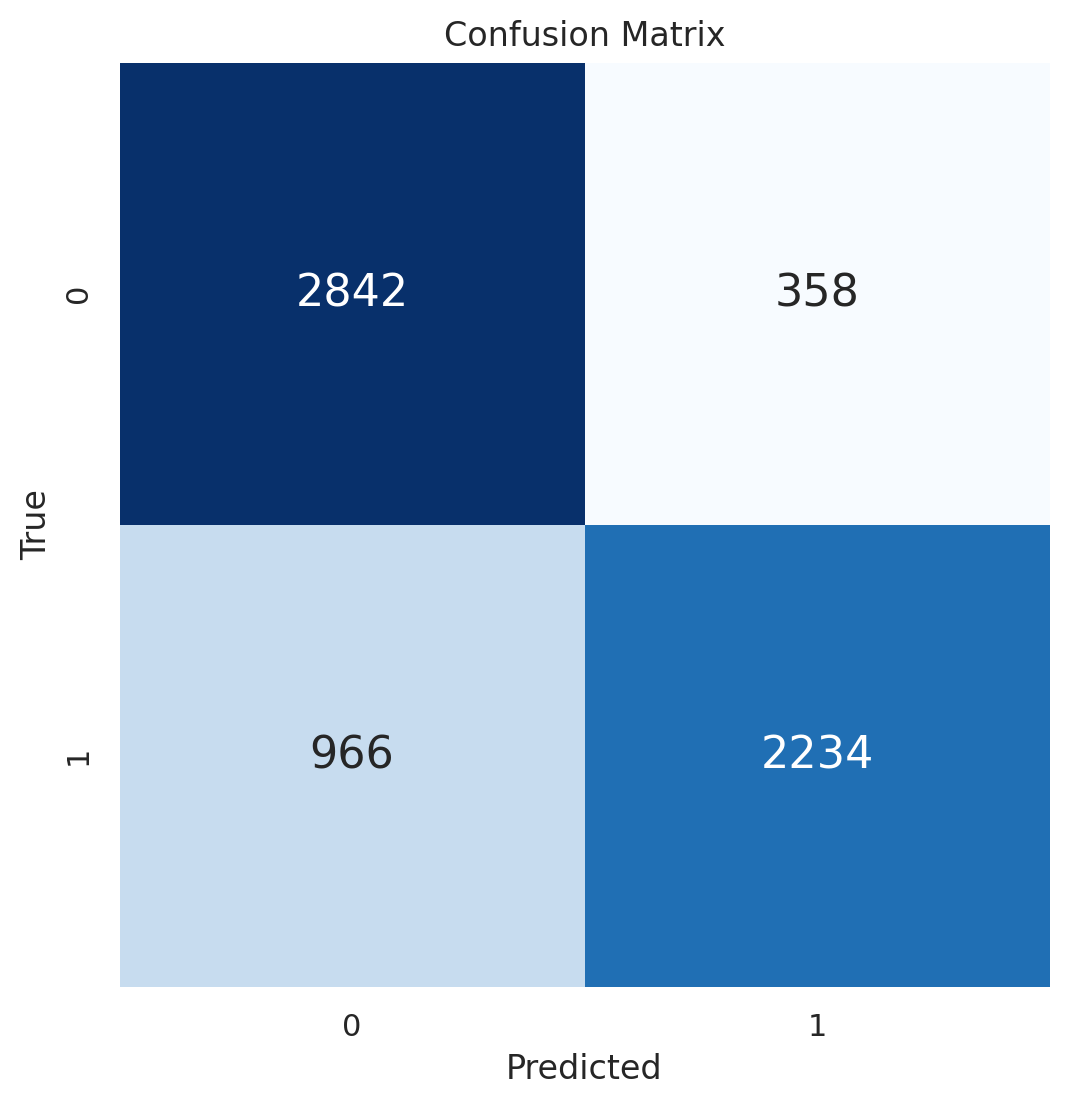

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_mat = confusion_matrix(y_test, y_pred)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      3200
           1       0.86      0.70      0.77      3200

    accuracy                           0.79      6400
   macro avg       0.80      0.79      0.79      6400
weighted avg       0.80      0.79      0.79      6400



In [19]:
model.save('xception_model.keras')

In [20]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

In [21]:
test_image_paths = []
for idx,i in enumerate(test_set.index[125:150]):
    test_image_paths.append(('../input/deepfake-faces/faces_224/'+test_set.loc[i,'videoname'][:-4]+'.jpg', test_set.loc[i,'label']))

AttributeError: '_BatchDataset' object has no attribute 'index'

In [ ]:
plt.figure(figsize=(15,15), dpi=300)

for idx, (image_path, label) in enumerate(test_image_paths):
    processed_image = preprocess_image(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(processed_image)
    
    # Threshold for binary classification: 0.33
    predicted_class = "FAKE" if prediction[0, 0] > 0.5 else "REAL"
    
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.xlabel(f'{predicted_class} | {prediction[0, 0]:.2f} | {"T" if predicted_class == label else "F"}')
    
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    """
    Load an image from the path and preprocess it for the model.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Adjust the size according to your model input
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

plt.figure(figsize=(15, 15), dpi=300)

# Iterate over a subset of the training set
for idx, i in enumerate(train_set.index[75:100]):
    plt.subplot(5, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Get the image path and label
    image_path = f"../input/deepfake-faces/faces_224/{Train_set.loc[i, 'videoname'][:-4]}.jpg"
    label = Train_set.loc[i, 'label']
    # Preprocess the image and make a prediction
    processed_image = preprocess_image(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(processed_image)
    
    # Threshold for binary classification: 0.33
    predicted_class = "FAKE" if prediction[0, 0] > 0.5 else "REAL"
    
    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    true_class = "FAKE" if label == 'FAKE' else "REAL"
    correctness = "T" if predicted_class == true_class else "F"
    plt.xlabel(f'{predicted_class} | {prediction[0, 0]:.2f} | {correctness}')
    
plt.tight_layout()
plt.show()